<a href="https://colab.research.google.com/github/Kuwar123/Fake_news_detection/blob/main/Fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fake and Real news Detection using LSTM and Deep Learning


Library Imports


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Conv1D,MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score

In [ ]:
fake = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/Fake.csv')

In [ ]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [ ]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

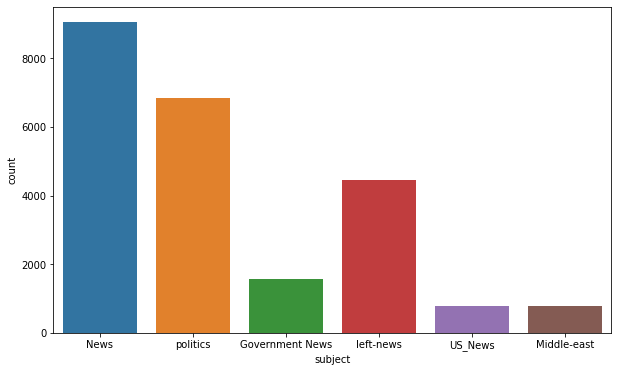

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='subject',data=fake)


WordCloud

In [ ]:
text = ' '.join(fake['text'].tolist())

In [ ]:
', '.join(['this','is','a','data'])

'this, is, a, data'

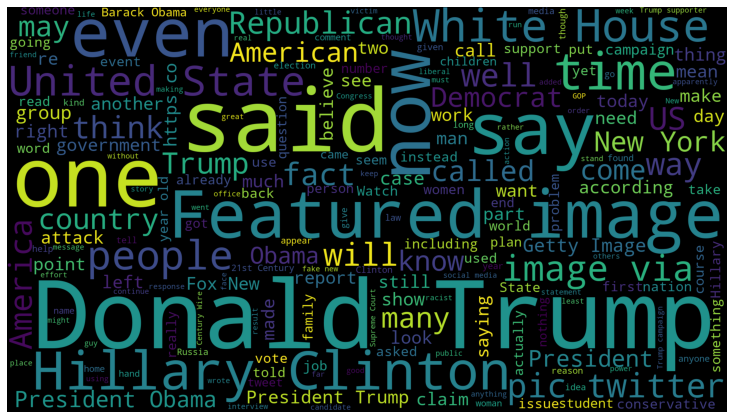

In [ ]:
wordcloud = WordCloud(width=1920,height=1080).generate(text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Exploring Real news

In [ ]:
real = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/True.csv')

In [ ]:
text = ' '.join(real['text'].tolist())

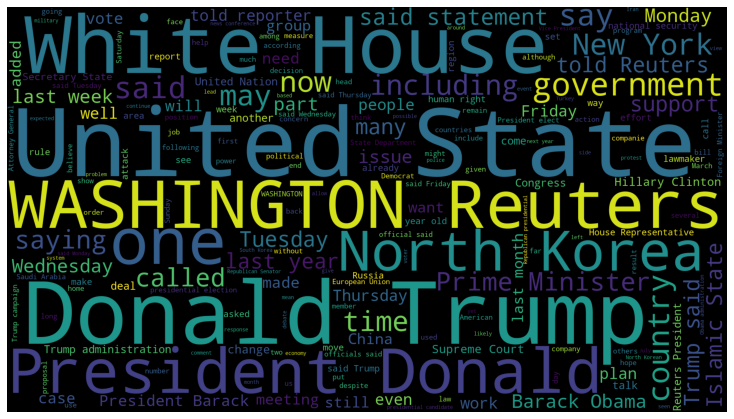

In [ ]:
wordcloud = WordCloud(width=1920,height=1080).generate(text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Cleaning Data

In [ ]:
real.sample(5)

,title,text,subject,date
14096,South Korea considers scrapping exercise with ...,SEOUL (Reuters) - South Korea is considering s...,worldnews,"November 23, 2017"
17518,"Wall Street raises targets on Netflix, citing ...",(Reuters) - Netflix Inc (NFLX.O) shares hit an...,worldnews,"October 13, 2017"
13404,Germany's Social Democrats refuse to jump into...,BERLIN (Reuters) - Germany s Social Democrat (...,worldnews,"November 30, 2017"
8964,"In campaign trail debut with Clinton, Warren s...",CINCINNATI (Reuters) - Liberal Elizabeth Warre...,politicsNews,"June 27, 2016"
18077,Conservative plotters told to get behind UK's ...,LONDON (Reuters) - Lawmakers in British Prime ...,worldnews,"October 7, 2017"


In [ ]:
unknown_publishers = []
for index ,row in enumerate(real.text.values):
  try:
    record = row.split('-',maxsplit=1)
    record[1]
    assert(len(record[0])<120)
  except:
    unknown_publishers.append(index)  

In [ ]:
len(unknown_publishers)

222

In [ ]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [ ]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [ ]:
real = real.drop(8970,axis=0)

In [ ]:
publisher = []
tmp_text = []
for index,row in enumerate(real.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append('Unknown')
    
  else:
    record = row.split('-',maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())


In [ ]:
real['publisher'] = publisher
real['text'] = tmp_text

In [ ]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [ ]:
real.shape

(21416, 5)

In [ ]:
empty_fake_index = [index for  index,text in enumerate(fake.text.to_list()) if str(text).strip()==""]

In [ ]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [ ]:
real['text'] = real['title'] + " " + real['text']
fake['text'] = fake['title'] + " " + fake['text']

In [ ]:
real['text'] = real['text'].apply(lambda x:str(x).lower())
fake['text'] = fake['text'].apply(lambda x:str(x).lower())


Preprocessing Text

In [ ]:
real['class'] = 1
fake['class'] = 0

In [ ]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [ ]:
real = real[['text','class']]

In [ ]:
fake = fake[['text','class']]

In [ ]:
data = real.append(fake,ignore_index=True)

In [ ]:
data.sample(5)

,text,class
20620,"norway's merkel, erna solberg hopes to beat hi...",1
6976,trump packs transition team with washington ve...,1
25737,breaking: yet another trump advisor caught wi...,0
34433,benghazi deputy chief lets it rip on hillary d...,0
36821,irony: only political party with black preside...,0


In [ ]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

     |████████████████████████████████| 12.0 MB 5.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-hdcd7dl0
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-hdcd7dl0
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=11754 sha256=707b3791cfd9e4c874fbbb8651014aee09f6168d870a9bbe86b0073c0cb80df6
  Stored in directory: /tmp/pip-ephem-wheel-cache-trkbkolz/wheels/0d/b3/29/bfe3deffda68980088d17b81331be6667e837ffb4a071bae82
Successfully built preprocess-kgptalkie


In [ ]:
import preprocess_kgptalkie as ps

In [ ]:
data['text']=data['text'].apply(lambda x :ps.remove_special_chars(x))

In [ ]:
ps.remove_special_chars('this ,. @ # is great')

'this is great'